In [ ]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,appearance_model_eight_teeth,appearance_model_four_teeth,load_image,load_landmark,gaussian_pyramid_down,tooth_splitter,tooth_models
from incisorseg.utils import *
from active_shape_models.models import GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.shape import Shape, ShapeList
import json
data = Dataset('../data/')

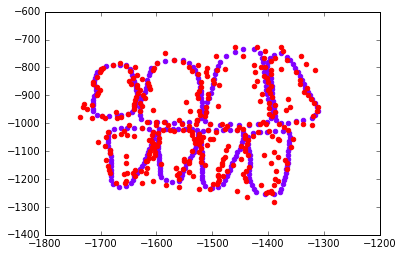

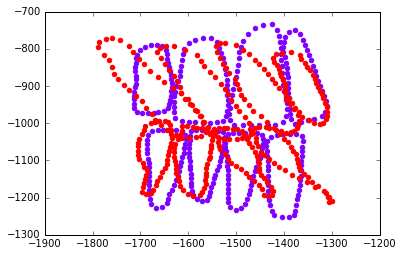

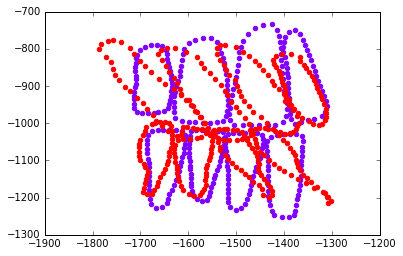

0.755214205186 0.493122239061 0.487020909315


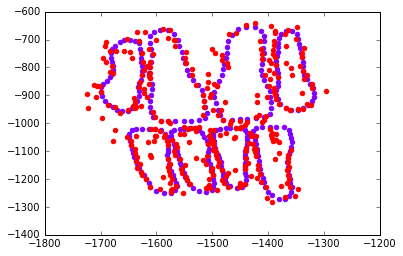

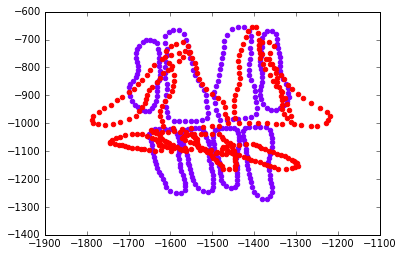

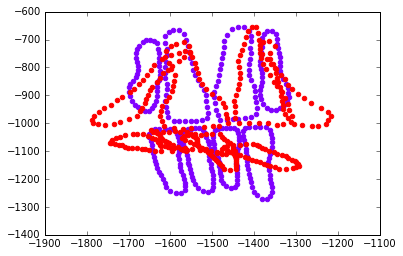

0.743606588465 0.350502519865 0.348494332012


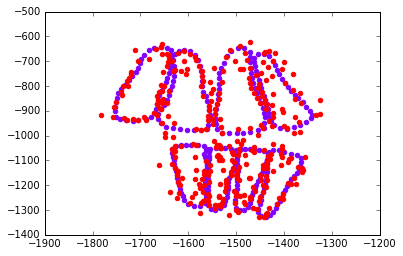

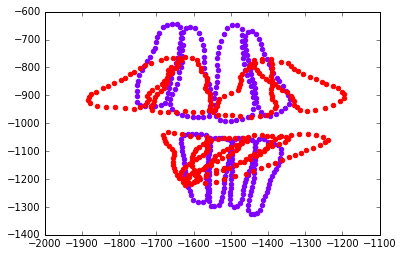

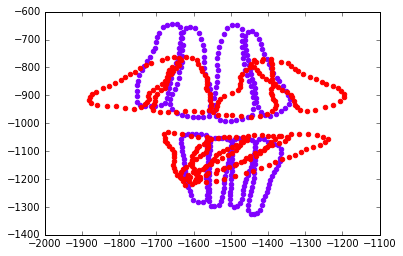

0.748781315175 0.377237667793 0.377085071967


In [ ]:
error_list = [];
i = 0
for split in LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    transformed_test_image = test_image
    transformed_training_images = training_images
    #transformed_training_images = [cv2.Laplacian(image,ddepth=cv2.CV_32F) for image in scaled_training_images]
    #transformed_test_image = cv2.Laplacian(scaled_test_image,ddepth=cv2.CV_32F)
    transformed_training_images = [cv2.medianBlur(image,7) for image in transformed_training_images]
    transformed_test_image = cv2.medianBlur(transformed_test_image,7)
    shape_model = PointDistributionModel(training_landmarks,use_transformation_matrix=False,project_to_tangent_space=False)
    grey_model = GreyModel(transformed_training_images, training_landmarks,patch_num_pixels=30, 
                           search_num_pixels=60, use_gradient=True,
                 normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
                 normal_point_neighborhood=2)
    active_shape_model = ActiveShapeModel(shape_model,grey_model)
    new_shape,_= grey_model.search(transformed_test_image,test_landmark)
    newer_shape,_,_ = shape_model.fit(new_shape)
    newest_shape,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=test_landmark)
    plot_shapes([test_landmark,new_shape])
    plot_shapes([test_landmark,newer_shape])
    plot_shapes([test_landmark,newest_shape])
    print split.get_dice_error_on_test(new_shape),split.get_dice_error_on_test(newer_shape),split.get_dice_error_on_test(newest_shape)
    error_list.append(split.get_dice_error_on_test(newest_shape))
    i = i+1
    if i >= 1:
        pass#break
print np.mean(np.array(error_list))